In [18]:
import numpy as np
from scipy import interpolate
from scipy.interpolate import UnivariateSpline, InterpolatedUnivariateSpline, interp1d
from astropy.cosmology import FlatLambdaCDM
from colossus.cosmology import cosmology
from colossus.halo import mass_adv
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('default')

def rho_cri(z, cosmo_h, G, omega_m, omega_d, m_solar, Mpc_to_m):
    '''
    Return Unit: msolar / MPC
    '''
    a = 1. + z
    H_0 = cosmo_h * 100 / (3.09e19)        #Unit of 1/s
    return (3 * H_0 ** 2)/(8 * np.pi * G) * (omega_m * a ** 3 + omega_d) / m_solar * Mpc_to_m ** 3

def battaglia_profile(r, Mvir, z, rho_critical, omega_b0, omega_m0, cosmo_h):
    '''
    Using Battaglia et al (2012). Eq. 10. 
    Input: M200 in solar mass and R200 in Mpc
    Return: Pressure profile in keV/cm^3 at radius r
    '''
    params = {'flat': True, 'H0': 70, 'Om0': 0.27, 'Ob0': 0.044, 'sigma8': 0.80, 'ns': 0.95}
    cosmology.addCosmology('myCosmo', **params)
    cosmo = cosmology.setCosmology('myCosmo')
    #Option to customize concentration, currently default, using Bullock et al. (2001)
    #cvir = concentration.concentration(Mvir, 'vir', z, model = 'ishiyama21')      #Ishiyama et al. (2021)
    M200, R200, c200 = mass_adv.changeMassDefinitionCModel(Mvir/cosmo_h, z, 'vir', '200c')
    M200 *= cosmo_h
    R200 = R200 / 1000 * cosmo_h
    
    R200 *= (1. + z)                            # Proper distance to Comoving distance
    x = r / R200
    msolar = 1.9889e30                          # kg
    mpc2cm = 3.0856e24
    G = 4.3e-9                                  # Mpc Mo^-1 (km/s)^2 
    alpha = 1.0
    gamma = -0.3
    P200 = 200. * rho_critical * omega_b0 * G * M200 / omega_m0 / 2. / (R200 / (1. + z))    # Msun km^2 / Mpc^3 / s^2

    P0 = 18.1 * ((M200 / 1e14)**0.154 * (1. + z)**-0.758)
    xc = 0.497 * ((M200 / 1e14)**-0.00865 * (1. + z)**0.731)
    beta = 4.35 * ((M200 / 1e14)**0.0393 * (1. + z)**0.415) 
    pth = P200 * P0 * (x / xc)**gamma * (1. + (x/xc))**(-1. * beta)      # Msun km^2 / Mpc^3 / s^2

    pth *= (msolar * 6.24e15 * 1e6 / mpc2cm**3)       # keV/cm^3
    p_e = pth * 0.518       # Vikram et al (2016)
    return p_e

#new x-ray profile(?)
def xray_pro(radius, B):
    y = np.power(1+np.power(radius,2),(.5-3*B))
    return y

def make_proj_image_new(radius, profile,maxRadius=0.5,pixel_scale=0.005,extrapolate=False):
    '''
    Input: Profile as function of Radius, maxRadius (default to 0.5) & pixel_scale (default to 0.005) in Mpc
    Return: 2D profile
    '''
    image_size = np.int_(np.round(maxRadius*2/pixel_scale)/2+1)

    if extrapolate:
        profile_spline = interp1d(radius, profile, kind = 3, bounds_error=False, fill_value="extrapolate")
    else:
        profile_spline = interp1d(radius, profile, bounds_error=False)

    x,y=np.meshgrid(np.arange(image_size),np.arange(image_size))
    r = np.sqrt((x-image_size//2)**2+(y-image_size//2)**2)*pixel_scale
    image = profile_spline(r)
    return image
    
def f_sz(f, T_CMB):
    '''
    Input: Observation frequency f, Temperature of cmb T_CMB
    Return: Radiation frequency
    '''
    planck_const = 6.626e-34         #m^2 kg/s
    boltzman_const = 1.38e-23
    x = planck_const * f / boltzman_const / T_CMB
    return x * (np.exp(x) + 1) / (np.exp(x) - 1) - 4

def Mpc_to_arcmin(r, z):
    '''
    Input: distance r, redshift
    Return: angular scale
    '''
    cosmo = FlatLambdaCDM(H0=70, Om0=0.27)
    Kpc_per_arcmin = cosmo.kpc_comoving_per_arcmin(z).value
    Mpc_per_arcmin = Kpc_per_arcmin/1000
    return r / Mpc_per_arcmin

def plot_img(image, mode = 1, cmb = 0):
    '''
    Input: image, mode (option of 0.5/5 Mpc, default to 0.5), cmb (option of y/delta_T, default to y)
    Return: angular scale
    '''
    if mode:    # 0.5 Mpc
        values = [-0.4, -0.2, 0, 0.2, 0.4]
        e = [-0.5, 0.5, -0.5, 0.5]
    else:   # 5 Mpc
        values = [-4, -2, 0, 2, 4]
        e = [-5, 5, -5, 5]
    if cmb:
        option = 'ocean'
        title = '$\Delta$T'
        cbar_label = r'$uK$'
    else:
        option = 'hot'
        title = 'Y'
        cbar_label = r'$Y$'
        if mode == 0:
            cbar_label = r'$\log_{10}Y$'
    fig, ax = plt.subplots(1,1)
    img = ax.imshow(image, cmap=option, extent = e)
    x_label_list = Mpc_to_arcmin(values, z)
    x_label_list = np.round(x_label_list)
    ax.set_xticks(values)
    ax.set_xticklabels(x_label_list)
    cbar = fig.colorbar(img)
    cbar.ax.set_ylabel(cbar_label)
    plt.title(title)
    plt.xlabel('arcmin')
    plt.ylabel(r'Mpc')
    
def plot_y(r, y):
    '''
    Input: profile as function of radius
    Return: visulization (non-log & log scale)
    '''
    fig,ax = plt.subplots(1,2,figsize = (12,5))
    plt.subplots_adjust(wspace = 0.3)
    ax[0].plot(r, y, color = "red", label = "non-log")
    ax[0].set_xlabel("Mpc")
    ax[0].set_ylabel(r'Mpc$^{-1}$')
    ax[0].title.set_text("Y z="+str(z))
    ax[1].loglog(r, y, color = "blue", label = "log")
    ax[1].set_xlabel("Mpc")
    ax[1].set_ylabel(r'Mpc$^{-1}$')
    ax[1].title.set_text("Y(Log) z="+str(z))
    plt.show()
    
    
def generate_img(radius, profile, plain_y = False, xray = False, Mpc5 = False, Mpc = False, cmb = False, cmb_n = False, y_n = False):
    if plain_y:
        plot_y(radius, profile)
    if xray:
        plot_y(radius, xray_pro)
        
    if Mpc5:
        log_image = make_proj_image_new(radius,np.log10(y_pro),maxRadius=5,pixel_scale=0.05,extrapolate=True)
        plot_img(log_image, 0)

    
    y_img = make_proj_image_new(radius,y_pro,extrapolate=True)
    
    f = 1.5e11               #Hz
    t_cmb = 2.725            #K
    fsz = f_sz(f, t_cmb)
    cmb_img = y_img * fsz * t_cmb * 1e6
    
    noise_level = 0.06 * cmb_img[50,60]                      #Can change level
    noise = np.random.normal(0, 1, (101,101)) * noise_level
    CMB_noise = cmb_img + noise
    
    y_noise = CMB_noise / fsz / t_cmb / 1e6
    
    if Mpc:
        plot_img(y_img)
    if cmb:
        plot_img(cmb_img, cmb = 1)
    if cmb_n:
        plot_img(CMB_noise, cmb = 1)
    if y_n:
        plot_img(y_noise)

### Constants

In [19]:
G = 6.6743e-11        #m^3/Kg/s^2
m_sun = 1.98847e30       #Kg
Thomson_sec = 6.65246e-29       #m^2
m_electron = 9.11e-31        #Kg
c = 299792458     #m/s
Mpc_to_m = 3.09e22
kevcm_to_jm = 1.6e-16 * 1e6

### Cosmological Parameters 

In [20]:
omega_b0 = 0.044
omega_m0 = 0.27
omega_d0 = 1 - omega_m0
cosmo_h = 0.7

### Varable Inputs

Electron Pressure Profile evaluated at given Radius of galaxy cluster defined by Mass and Redshift

In [21]:
Mass = 1e13
z = 0.1
radius = np.linspace(0.1, 2, 10)
rho_critical = rho_cri(z, cosmo_h, G, omega_m0, omega_d0, m_sun, Mpc_to_m)
battaglia_pro = np.array([battaglia_profile(r, Mass, z, rho_critical, omega_b0, omega_m0, cosmo_h) for r in np.linspace(0.1, 2, 10)])

#xray prof
Beta = 1.5
xray_pro = np.array([xray_pro(radius, Beta) for radius in np.linspace(0.1, 2, 10)])

Deleted outdated persistence file, no further action needed.
Deleted outdated persistence file, no further action needed.
Deleted outdated persistence file, no further action needed.
Deleted outdated persistence file, no further action needed.
Deleted outdated persistence file, no further action needed.
Deleted outdated persistence file, no further action needed.
Deleted outdated persistence file, no further action needed.
Deleted outdated persistence file, no further action needed.
Deleted outdated persistence file, no further action needed.
Deleted outdated persistence file, no further action needed.


Mapping to Compton-Y Profile

In [22]:
constant = Thomson_sec / m_electron / (c ** 2)         #s^2/kg
new_battaglia = battaglia_pro * kevcm_to_jm
y_pro = new_battaglia * constant * Mpc_to_m

## Ploting Options 

### Plain Y

Visulization of Compton-Y profile with respect to radius

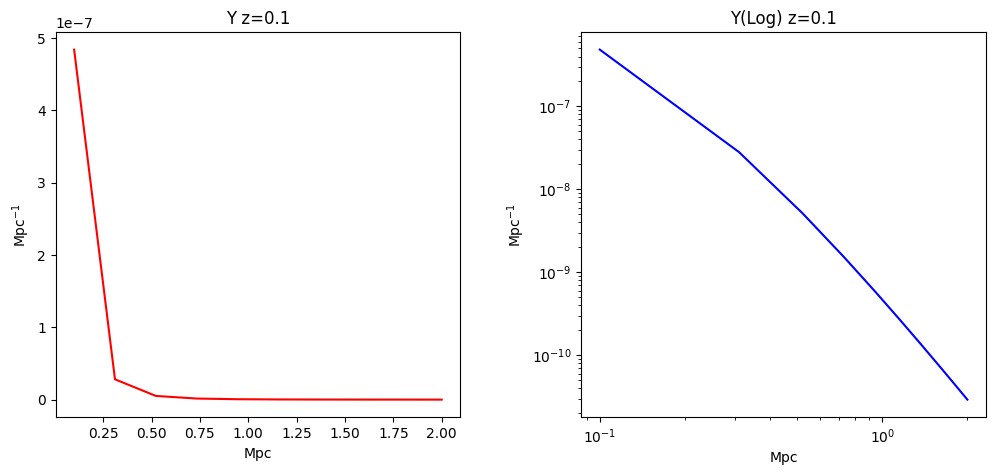

In [23]:
generate_img(radius, y_pro, plain_y = True)

### Xray

Visulization of xray profile with respect to radius

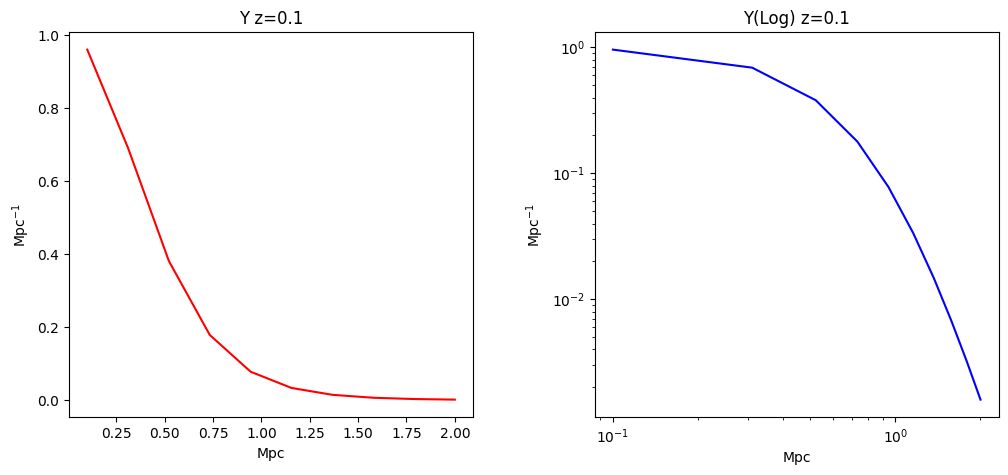

In [24]:
generate_img(radius, xray_pro, xray = True)

### Mpc 5

2D Image of Compton-Y within the range of 5 Mpc (log-scaled)

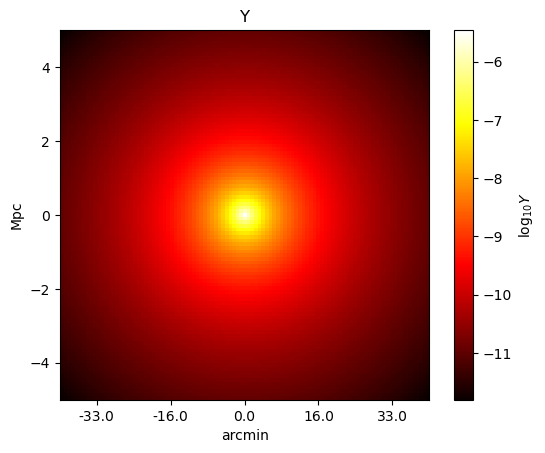

In [7]:
generate_img(radius, y_pro, Mpc5 = True)

### Mpc 0.5

2D Image of Compton-Y within the range of 0.5 Mpc

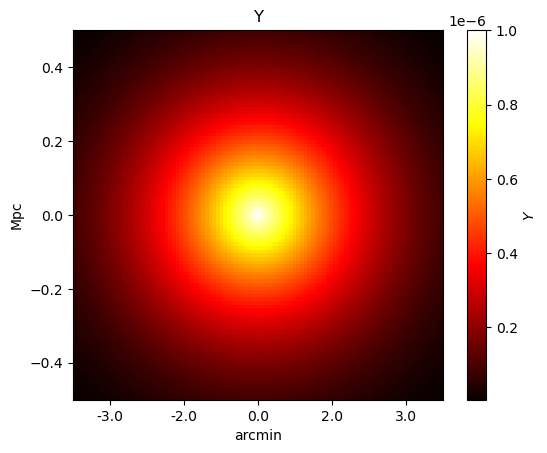

In [8]:
generate_img(radius, y_pro, Mpc = True)

### CMB 

CMB Temperature Decrement (at 150 GHz) (scaled to uK)

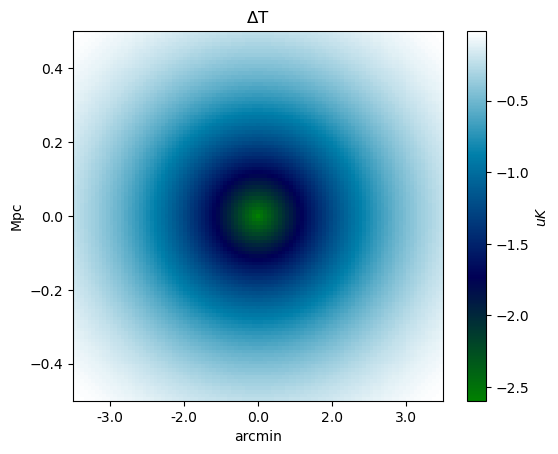

In [9]:
generate_img(radius, y_pro, cmb = True)

### CMB with noise

CMB Temperature Decrement with Gaussian noise

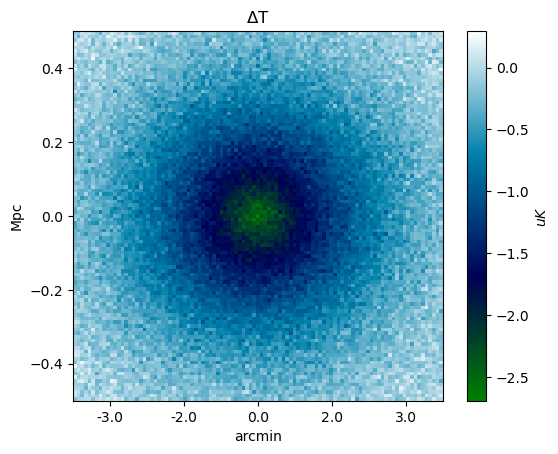

In [10]:
generate_img(radius, y_pro, cmb_n = True)

### Compton-Y with noise

Reverse mapping back to Compton-Y

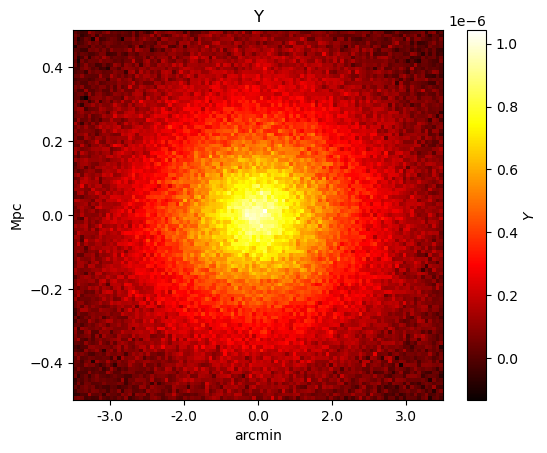

In [11]:
generate_img(radius, y_pro, y_n = True)